# Import

In [1]:
# Basic
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

# ML Toolkit
from robusta.crossval import *
from robusta.selector import *
from robusta.pipeline import *
from robusta.preprocessing import *

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import *

# Model
from sklearn.linear_model import Ridge

# Plot
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Data

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=200, n_features=50, n_informative=5, 
                       random_state=666)

X = pd.DataFrame(X)
y = pd.Series(y)

X.rename(columns=lambda x: 'x{}'.format(x), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Task & Model

In [3]:
get_score = lambda y_true, y_pred: -mean_squared_error(y_true, y_pred)
scoring = 'neg_mean_squared_error'

cv = 5

model = Ridge()

# Baseline

In [4]:
_, y_pred = crossval_predict(model, cv, X_train, y_train, X_new=X_test,
                             scoring=scoring, verbose=2, n_jobs=None)

get_score(y_test, y_pred)

[06:00:16]  Ridge

[06:00:16]  FOLD  0:   -6.8685
[06:00:16]  FOLD  1:   -8.7267
[06:00:16]  FOLD  2:   -10.6242
[06:00:16]  FOLD  3:   -20.1918
[06:00:16]  FOLD  4:   -13.1002

[06:00:16]  AVERAGE:   -11.9023 ± 4.6305



-9.600466067788235

# Differential Evolution

In [16]:
selector = GeneticSelector(model, cv, scoring, crossover=0.3, max_iter=1000)
selector.fit(X_train, y_train)

[06:04:11] GENERATION 1
[06:04:11] ITER: 1/1000      SUBSET: 25/50      SCORE: -6462.9118 ± 1608.4192      ETA: 18 sec
[06:04:11] ITER: 2/1000      SUBSET: 27/50      SCORE: -14536.9212 ± 2696.2780      ETA: 19 sec
[06:04:11] ITER: 3/1000      SUBSET: 29/50      SCORE: -25796.7148 ± 5551.4917      ETA: 19 sec
[06:04:11] ITER: 4/1000      SUBSET: 24/50      SCORE: -21597.4998 ± 3825.1467      ETA: 19 sec
[06:04:11] ITER: 5/1000      SUBSET: 28/50      SCORE: -19197.2148 ± 6961.8568      ETA: 19 sec
[06:04:11] ITER: 6/1000      SUBSET: 30/50      SCORE: -5974.3811 ± 674.5077      ETA: 19 sec
[06:04:11] ITER: 7/1000      SUBSET: 20/50      SCORE: -21710.9042 ± 5176.6345      ETA: 19 sec
[06:04:11] ITER: 8/1000      SUBSET: 28/50      SCORE: -15773.4751 ± 3454.1792      ETA: 19 sec
[06:04:11] ITER: 9/1000      SUBSET: 26/50      SCORE: -12036.8544 ± 2642.8717      ETA: 19 sec
[06:04:11] ITER: 10/1000      SUBSET: 20/50      SCORE: -14190.7553 ± 1616.5851      ETA: 19 sec
[06:04:11] ITER: 1

[06:04:14] ITER: 85/1000      SUBSET: 23/50      SCORE: -1704.7958 ± 292.9859      ETA: 18 sec
[06:04:14] ITER: 86/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 18 sec
[06:04:14] ITER: 87/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 18 sec
[06:04:14] GENERATION 11
[06:04:14] ITER: 88/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 89/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 90/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 91/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 92/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 93/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 94/1000      SUBSET: 23/50      SCORE: -1704.8219 ± 350.6863      ETA: 17 sec
[06:04:14] ITER: 95/1000 

[06:04:17] ITER: 169/1000      SUBSET: 24/50      SCORE: -1735.5659 ± 380.2305      ETA: 16 sec
[06:04:17] ITER: 170/1000      SUBSET: 23/50      SCORE: -1653.5272 ± 361.5285      ETA: 16 sec
[06:04:17] ITER: 171/1000      SUBSET: 23/50      SCORE: -1653.5272 ± 361.5285      ETA: 16 sec
[06:04:17] ITER: 172/1000      SUBSET: 23/50      SCORE: -4.3708 ± 0.7593      ETA: 16 sec
[06:04:17] ITER: 173/1000      SUBSET: 22/50      SCORE: -1627.6309 ± 343.5366      ETA: 16 sec
[06:04:17] ITER: 174/1000      SUBSET: 23/50      SCORE: -1653.5272 ± 361.5285      ETA: 16 sec
[06:04:17] ITER: 175/1000      SUBSET: 23/50      SCORE: -1653.5272 ± 361.5285      ETA: 16 sec
[06:04:17] ITER: 176/1000      SUBSET: 23/50      SCORE: -4.3865 ± 0.8184      ETA: 16 sec
[06:04:17] ITER: 177/1000      SUBSET: 23/50      SCORE: -1653.5272 ± 361.5285      ETA: 16 sec
[06:04:17] GENERATION 22
[06:04:17] ITER: 178/1000      SUBSET: 23/50      SCORE: -4.3708 ± 0.7593      ETA: 16 sec
[06:04:17] ITER: 179/1000     

[06:04:20] ITER: 261/1000      SUBSET: 20/50      SCORE: -3.9143 ± 0.7056      ETA: 14 sec
[06:04:20] ITER: 262/1000      SUBSET: 22/50      SCORE: -4.1705 ± 0.6877      ETA: 14 sec
[06:04:20] ITER: 263/1000      SUBSET: 20/50      SCORE: -3.9444 ± 0.5431      ETA: 14 sec
[06:04:20] ITER: 264/1000      SUBSET: 20/50      SCORE: -4.0302 ± 0.7121      ETA: 14 sec
[06:04:20] ITER: 265/1000      SUBSET: 20/50      SCORE: -7316.2726 ± 2170.0767      ETA: 14 sec
[06:04:20] GENERATION 32
[06:04:20] ITER: 266/1000      SUBSET: 20/50      SCORE: -1694.4049 ± 413.6170      ETA: 14 sec
[06:04:20] ITER: 267/1000      SUBSET: 21/50      SCORE: -4.0179 ± 0.5175      ETA: 14 sec
[06:04:20] ITER: 268/1000      SUBSET: 19/50      SCORE: -3.8473 ± 0.7045      ETA: 14 sec
[06:04:20] ITER: 269/1000      SUBSET: 20/50      SCORE: -3.9143 ± 0.7056      ETA: 14 sec
[06:04:20] ITER: 270/1000      SUBSET: 20/50      SCORE: -3.9143 ± 0.7056      ETA: 14 sec
[06:04:20] ITER: 271/1000      SUBSET: 20/50      SCOR

[06:04:23] ITER: 351/1000      SUBSET: 18/50      SCORE: -3.7647 ± 0.7429      ETA: 12 sec
[06:04:23] ITER: 352/1000      SUBSET: 20/50      SCORE: -4.3555 ± 1.3073      ETA: 12 sec
[06:04:23] ITER: 353/1000      SUBSET: 19/50      SCORE: -3.7921 ± 0.7697      ETA: 12 sec
[06:04:23] ITER: 354/1000      SUBSET: 18/50      SCORE: -6491.8685 ± 1929.4178      ETA: 12 sec
[06:04:23] GENERATION 42
[06:04:23] ITER: 355/1000      SUBSET: 18/50      SCORE: -3.7168 ± 0.7401      ETA: 12 sec
[06:04:23] ITER: 356/1000      SUBSET: 18/50      SCORE: -3.7647 ± 0.7429      ETA: 12 sec
[06:04:23] GENERATION 43
[06:04:23] ITER: 357/1000      SUBSET: 17/50      SCORE: -3.5860 ± 0.7749      ETA: 12 sec
[06:04:23] ITER: 358/1000      SUBSET: 17/50      SCORE: -3.5860 ± 0.7749      ETA: 12 sec
[06:04:23] ITER: 359/1000      SUBSET: 18/50      SCORE: -3.7647 ± 0.7429      ETA: 12 sec
[06:04:23] ITER: 360/1000      SUBSET: 17/50      SCORE: -7022.1013 ± 1969.0881      ETA: 12 sec
[06:04:23] ITER: 361/1000   

[06:04:26] ITER: 441/1000      SUBSET: 16/50      SCORE: -3.5545 ± 0.6849      ETA: 10 sec
[06:04:26] ITER: 442/1000      SUBSET: 14/50      SCORE: -3.3117 ± 0.8305      ETA: 10 sec
[06:04:26] ITER: 443/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 10 sec
[06:04:26] ITER: 444/1000      SUBSET: 13/50      SCORE: -3.2227 ± 0.8226      ETA: 10 sec
[06:04:26] ITER: 445/1000      SUBSET: 14/50      SCORE: -3.3117 ± 0.8305      ETA: 10 sec
[06:04:26] ITER: 446/1000      SUBSET: 13/50      SCORE: -12670.0970 ± 3083.9009      ETA: 10 sec
[06:04:26] GENERATION 57
[06:04:26] ITER: 447/1000      SUBSET: 13/50      SCORE: -3.2098 ± 0.7531      ETA: 10 sec
[06:04:26] ITER: 448/1000      SUBSET: 13/50      SCORE: -3.2098 ± 0.7531      ETA: 10 sec
[06:04:26] ITER: 449/1000      SUBSET: 13/50      SCORE: -3.1971 ± 0.7324      ETA: 10 sec
[06:04:26] ITER: 450/1000      SUBSET: 13/50      SCORE: -3.2098 ± 0.7531      ETA: 10 sec
[06:04:26] ITER: 451/1000      SUBSET: 12/50      SCORE: -

[06:04:29] ITER: 535/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 9 sec
[06:04:29] ITER: 536/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 9 sec
[06:04:29] ITER: 537/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 9 sec
[06:04:29] GENERATION 67
[06:04:29] ITER: 538/1000      SUBSET: 13/50      SCORE: -3.2198 ± 0.6687      ETA: 9 sec
[06:04:29] ITER: 539/1000      SUBSET: 16/50      SCORE: -3.5954 ± 1.1790      ETA: 8 sec
[06:04:29] ITER: 540/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 8 sec
[06:04:29] ITER: 541/1000      SUBSET: 11/50      SCORE: -6285.6082 ± 919.6062      ETA: 8 sec
[06:04:29] ITER: 542/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 8 sec
[06:04:29] ITER: 543/1000      SUBSET: 12/50      SCORE: -3.1337 ± 0.7541      ETA: 8 sec
[06:04:29] ITER: 544/1000      SUBSET: 12/50      SCORE: -6559.7718 ± 2147.4816      ETA: 8 sec
[06:04:29] ITER: 545/1000      SUBSET: 12/50      SCORE: -3.1337

[06:04:32] ITER: 627/1000      SUBSET: 11/50      SCORE: -3.0824 ± 0.7475      ETA: 7 sec
[06:04:32] ITER: 628/1000      SUBSET: 11/50      SCORE: -3.0824 ± 0.7475      ETA: 7 sec
[06:04:32] GENERATION 79
[06:04:32] ITER: 629/1000      SUBSET: 13/50      SCORE: -3.2655 ± 0.8018      ETA: 7 sec
[06:04:32] ITER: 630/1000      SUBSET: 10/50      SCORE: -4120.2324 ± 742.6353      ETA: 7 sec
[06:04:32] ITER: 631/1000      SUBSET: 13/50      SCORE: -3.3229 ± 0.9307      ETA: 7 sec
[06:04:32] ITER: 632/1000      SUBSET: 13/50      SCORE: -3.2499 ± 0.8246      ETA: 7 sec
[06:04:32] GENERATION 80
[06:04:32] ITER: 633/1000      SUBSET: 12/50      SCORE: -3.1266 ± 0.7412      ETA: 7 sec
[06:04:32] ITER: 634/1000      SUBSET: 11/50      SCORE: -3.0824 ± 0.7475      ETA: 7 sec
[06:04:32] ITER: 635/1000      SUBSET: 10/50      SCORE: -3.0794 ± 0.7686      ETA: 7 sec
[06:04:32] ITER: 636/1000      SUBSET: 11/50      SCORE: -3.0824 ± 0.7475      ETA: 7 sec
[06:04:32] ITER: 637/1000      SUBSET: 10/50 

[06:04:35] ITER: 717/1000      SUBSET: 10/50      SCORE: -3.0794 ± 0.7686      ETA: 5 sec
[06:04:35] GENERATION 93
[06:04:35] ITER: 718/1000      SUBSET: 11/50      SCORE: -3.1755 ± 0.7976      ETA: 5 sec
[06:04:35] ITER: 719/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 720/1000      SUBSET: 11/50      SCORE: -3.1648 ± 0.8435      ETA: 5 sec
[06:04:35] ITER: 721/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 722/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 723/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 724/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 725/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 726/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA: 5 sec
[06:04:35] ITER: 727/1000      SUBSET: 9/50      SCORE: -2.9973 ± 0.6908      ETA:

[06:04:38] ITER: 808/1000      SUBSET: 8/50      SCORE: -2.9338 ± 0.5851      ETA: 3 sec
[06:04:38] ITER: 809/1000      SUBSET: 8/50      SCORE: -2.9540 ± 0.7344      ETA: 3 sec
[06:04:38] ITER: 810/1000      SUBSET: 10/50      SCORE: -3.3181 ± 0.9355      ETA: 3 sec
[06:04:38] ITER: 811/1000      SUBSET: 11/50      SCORE: -3.1889 ± 0.7391      ETA: 3 sec
[06:04:38] ITER: 812/1000      SUBSET: 7/50      SCORE: -2.8747 ± 0.6766      ETA: 3 sec
[06:04:38] ITER: 813/1000      SUBSET: 9/50      SCORE: -3.0099 ± 0.6408      ETA: 3 sec
[06:04:38] ITER: 814/1000      SUBSET: 8/50      SCORE: -2.9506 ± 0.7387      ETA: 3 sec
[06:04:38] ITER: 815/1000      SUBSET: 8/50      SCORE: -2.9506 ± 0.7387      ETA: 3 sec
[06:04:38] ITER: 816/1000      SUBSET: 9/50      SCORE: -3.0397 ± 0.5984      ETA: 3 sec
[06:04:38] GENERATION 105
[06:04:38] ITER: 817/1000      SUBSET: 8/50      SCORE: -2.9506 ± 0.7387      ETA: 3 sec
[06:04:39] ITER: 818/1000      SUBSET: 8/50      SCORE: -2.9338 ± 0.5851      ETA:

[06:04:41] ITER: 901/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:41] ITER: 902/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:41] ITER: 903/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:41] ITER: 904/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:41] ITER: 905/1000      SUBSET: 11/50      SCORE: -2.9615 ± 0.6983      ETA: 1 sec
[06:04:41] GENERATION 117
[06:04:41] ITER: 906/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:42] ITER: 907/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:42] ITER: 908/1000      SUBSET: 9/50      SCORE: -2.9773 ± 0.6680      ETA: 1 sec
[06:04:42] ITER: 909/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:42] ITER: 910/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 1 sec
[06:04:42] ITER: 911/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 

[06:04:44] ITER: 991/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 175 ms
[06:04:44] ITER: 992/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 156 ms
[06:04:44] ITER: 993/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 136 ms
[06:04:44] ITER: 994/1000      SUBSET: 7/50      SCORE: -2.8422 ± 0.6728      ETA: 117 ms
[06:04:44] ITER: 995/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 97 ms
[06:04:44] GENERATION 130
[06:04:45] ITER: 996/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 78 ms
[06:04:45] ITER: 997/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 58 ms
[06:04:45] ITER: 998/1000      SUBSET: 10/50      SCORE: -2.9941 ± 0.6924      ETA: 39 ms
[06:04:45] ITER: 999/1000      SUBSET: 6/50      SCORE: -2.8287 ± 0.6684      ETA: 19 ms
[06:04:45] ITER: 1000/1000      SUBSET: 9/50      SCORE: -3.0743 ± 0.8683      ETA: 0 ms
Iterations limit exceed!


GeneticSelector(crossover=0.3, cv=5,
                estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                max_iter=None, normalize=False,
                                random_state=None, solver='auto', tol=0.001),
                max_iter=1000, max_time=None, mut_prob=0.1, mut_rate=0.05,
                n_digits=4, n_jobs=None, pop_size=20, random_state=None,
                scoring='neg_mean_squared_error', std=-0.1, verbose=1)

<IPython.core.display.Javascript object>


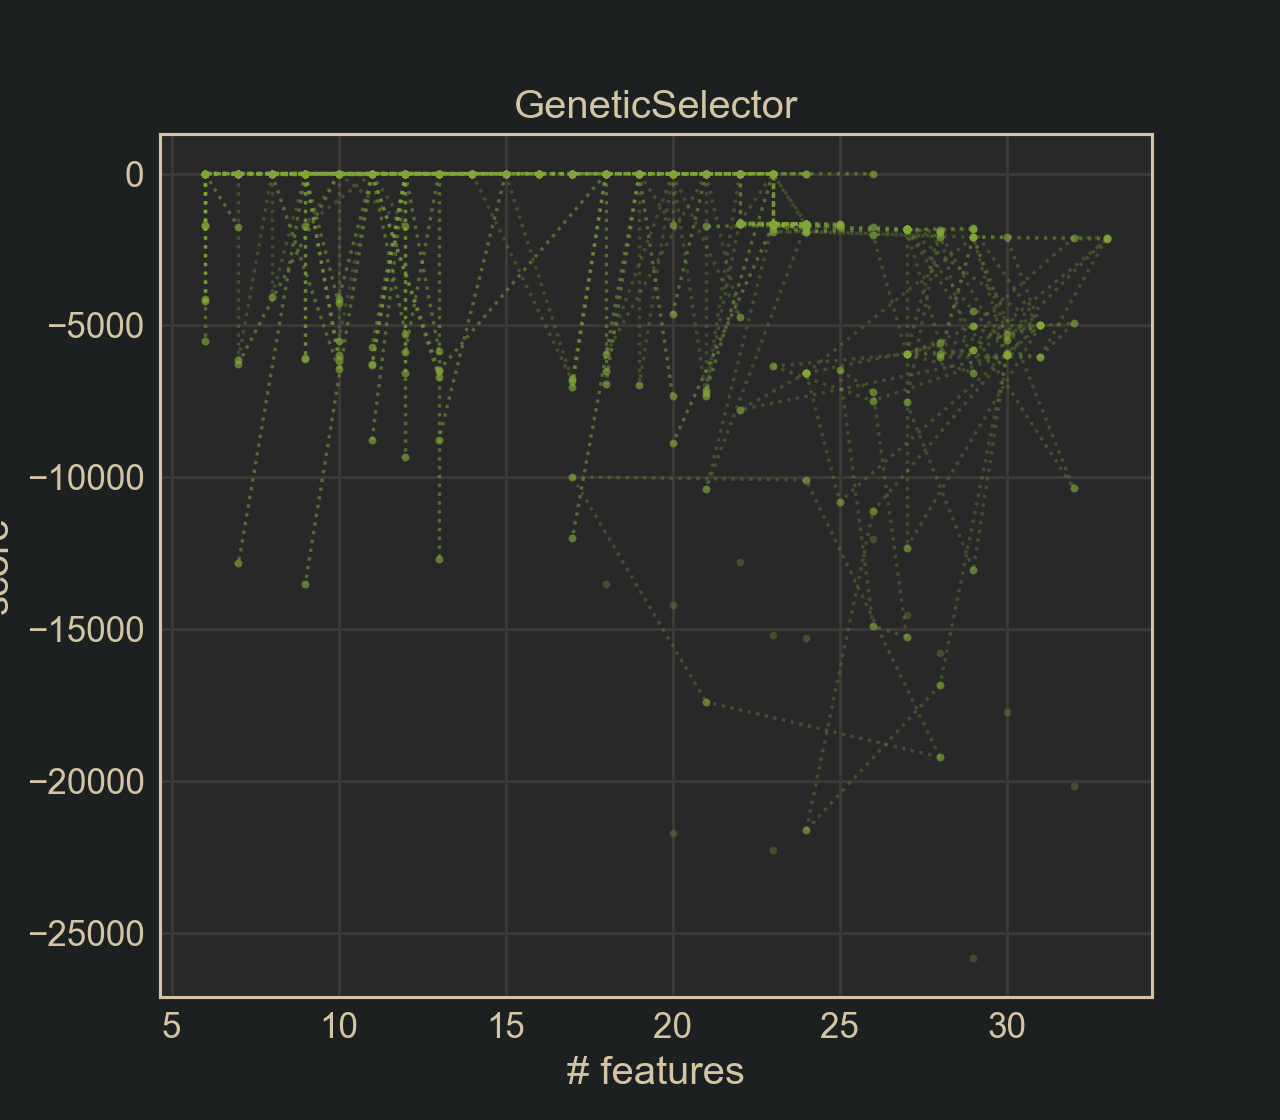

In [17]:
%matplotlib notebook

fig, ax = selector.plot(marker='.', color='g', linestyle=':', alpha=0.3)

<IPython.core.display.Javascript object>


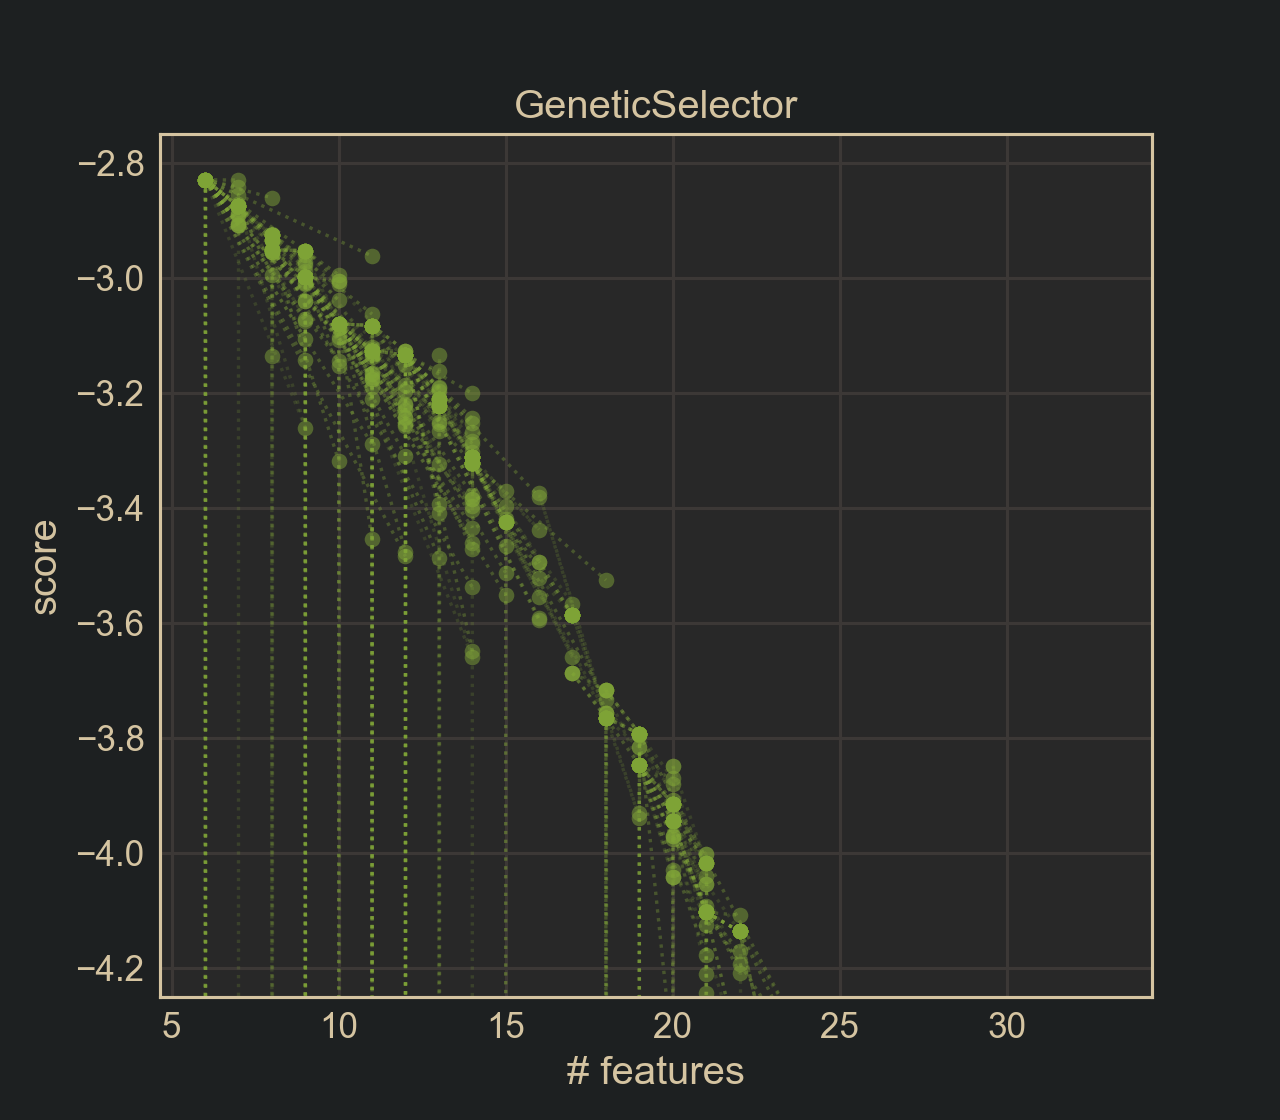

(-4.25, -2.75)

In [23]:
%matplotlib notebook

fig, ax = selector.plot(marker='o', color='g', linestyle=':', alpha=0.2)
ax.set_ylim([-4.25, -2.75])

In [24]:
X_train_ = selector.transform(X_train)
X_test_  = selector.transform(X_test)

_, y_pred = crossval_predict(model, cv, X_train_, y_train, X_new=X_test_,
                             scoring=scoring, verbose=2, n_jobs=-1)

get_score(y_test, y_pred)

[06:06:29]  Ridge

[06:06:29]  FOLD  0:   -2.6815
[06:06:30]  FOLD  1:   -3.3112
[06:06:30]  FOLD  2:   -1.9396
[06:06:30]  FOLD  3:   -3.8253
[06:06:30]  FOLD  4:   -2.3861

[06:06:30]  AVERAGE:   -2.8287 ± 0.6684



-3.4083453259280403

In [25]:
selector.get_subset()

FeatureSubset(['x19' 'x28' 'x29' 'x33' 'x36' 'x44'])

# Differential Evolution (Group)

In [26]:
K = 4

FUNC = lambda i, k: lambda x: (i*k <= int(x[1:]) < i*k+k)
NAME = lambda i, k: 'x{}-x{}'.format(i*k, i*k+k)

prep_pipe = FeatureUnion([
    (NAME(i, K), make_pipeline(ColumnFilter(FUNC(i, K)), ColumnGrouper(NAME(i, K))))
    for i in range(X.shape[1] // K)
])

X_train_ = prep_pipe.fit_transform(X_train)
X_test_ = prep_pipe.transform(X_test)

X_train_

x0-x4                                   x4-x8                      \
           x0        x1        x2        x3        x4        x5        x6   
114 -0.486192 -1.938886 -0.256917 -1.777999  0.247760 -0.595619 -0.039071   
173  0.748457  0.698708  1.189265 -0.599598  1.561570  1.308718  2.338996   
5   -0.467878  0.576009  1.022346  0.038953 -0.956788  0.224985 -1.821917   
126  0.211089  1.501854  0.340881  0.624708  0.411308  1.285594 -1.225613   
117 -0.064375  0.306493  0.444210  0.213568 -0.401956 -1.483166  1.678015   
..        ...       ...       ...       ...       ...       ...       ...   
106  0.616855  0.312075 -0.505777 -0.670151  0.747201  0.061859 -0.196145   
14   1.677128  1.597251 -0.197574 -0.428889 -0.626220 -0.118218 -1.853054   
92   1.319507 -0.374697  0.181910 -0.755100  0.749837  0.460237 -0.564057   
179  0.415623  1.316133 -1.388109  0.373652 -1.238512 -0.706704  0.962477   
102 -3.362675  0.483243 -1.490254 -0.423965 -0.426087 -0.421017  0.602901   

                 x8-x12            ...   x36-x40             x40-x44  \
           x7        x8        x9  ...       x38       x39       x40   
114 -0.222884  0.889465  0.404758  ... -0.458487 -2.165005 -0.089909   
173 -1.122985 -0.450689 -1.809998  ...  0.666394 -0.298129  0.092768   
5   -1.184674  0.065417 -0.364568  ... -1.108871  0.228600  0.819855   
126  1.748311 -0.018077  0.829071  ... -0.185490 -2.263209 -0.779928   
117  2.175929  1.754764  1.116414  ...  0.008828  0.124768 -0.425790   
..        ...       ...       ...  ...       ...       ...       ...   
106  0.398577  0.381527 -0.647369  ... -0.918174  0.649996 -1.607627   
14  -1.479926  1.178236  0.107689  ... -1.180548 -1.065820 -0.393123   
92  -0.185643 -0.502900 -1.192589  ...  0.647703 -1.771868  0.072571   
179 -1.459485 -1.157150 -1.330585  ... -0.156693  1.653879 -1.081663   
102  0.888508  0.210508  0.860256  ... -1.182391  0.432586 -0.737271   

                                    x44-x48                                
          x41       x42       x43       x44       x45       x46       x47  
114 -1.854918  0.196557 -0.395199  0.778831  0.047767  2.023676  0.649204  
173 -1.244179 -0.505445 -0.330599  1.119375 -1.401945 -0.116295  0.896283  
5    1.121932 -0.050049 -1.537254 -0.643587  1.509838 -1.902997 -0.671284  
126  0.391001  0.271996 -1.327205 -2.629107  0.633351  1.212322 -0.327737  
117  0.102304  1.446403  1.979220  0.274520  1.395296  0.023173  0.097237  
..        ...       ...       ...       ...       ...       ...       ...  
106 -0.150597  1.899005 -1.792778 -0.802560  2.104725 -0.104431  1.252028  
14  -0.239452  1.538816 -0.736272  1.860053 -0.042949 -3.103916  0.516133  
92  -0.372955  0.240492  0.034488 -0.991030  0.258708  0.282763 -1.376814  
179  0.109985 -0.710280  0.918187 -0.430674 -0.099369 -0.201156 -2.586488  
102  0.354971  0.454211  1.589926  1.032257 -0.678496 -0.072822 -1.156053  

[150 rows x 48 columns]

In [45]:
selector = GroupGeneticSelector(model, cv, scoring, crossover=0.5,
                                max_iter=200, pop_size=10,
                                mut_rate=0.1, mut_prob=0.2)
selector.fit(X_train_, y_train)

[06:09:18] GENERATION 1
[06:09:18] ITER: 1/200      SUBSET: 5/12      SCORE: -7544.6788 ± 2067.4619      ETA: 3 sec
[06:09:18] ITER: 2/200      SUBSET: 3/12      SCORE: -9091.9378 ± 1259.9961      ETA: 4 sec
[06:09:18] ITER: 3/200      SUBSET: 6/12      SCORE: -10599.1977 ± 1437.5027      ETA: 3 sec
[06:09:18] ITER: 4/200      SUBSET: 4/12      SCORE: -7200.5590 ± 2126.5960      ETA: 3 sec
[06:09:18] ITER: 5/200      SUBSET: 9/12      SCORE: -5497.9567 ± 776.7102      ETA: 3 sec
[06:09:18] ITER: 6/200      SUBSET: 6/12      SCORE: -14954.1138 ± 3659.4528      ETA: 3 sec
[06:09:18] ITER: 7/200      SUBSET: 7/12      SCORE: -17119.0995 ± 4506.0443      ETA: 4 sec
[06:09:18] ITER: 8/200      SUBSET: 4/12      SCORE: -20811.2455 ± 4619.7388      ETA: 3 sec
[06:09:18] ITER: 9/200      SUBSET: 7/12      SCORE: -4864.0235 ± 348.4426      ETA: 3 sec
[06:09:18] ITER: 10/200      SUBSET: 7/12      SCORE: -19080.0183 ± 3682.3886      ETA: 3 sec
[06:09:18] GENERATION 2
[06:09:18] ITER: 11/200     

[06:09:21] ITER: 92/200      SUBSET: 5/12      SCORE: -4.2660 ± 1.6870      ETA: 2 sec
[06:09:21] GENERATION 16
[06:09:21] ITER: 93/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:21] GENERATION 17
[06:09:21] ITER: 94/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:21] ITER: 95/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:21] ITER: 96/200      SUBSET: 3/12      SCORE: -6581.2190 ± 1362.2131      ETA: 2 sec
[06:09:21] ITER: 97/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:21] ITER: 98/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:21] ITER: 99/200      SUBSET: 3/12      SCORE: -6902.6408 ± 1535.2594      ETA: 2 sec
[06:09:21] ITER: 100/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:21] ITER: 101/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 2 sec
[06:09:22] GENERATION 18
[06:09:22] ITER: 102/200      SUBSET: 4/1

[06:09:24] ITER: 185/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 311 ms
[06:09:24] ITER: 186/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 290 ms
[06:09:24] ITER: 187/200      SUBSET: 6/12      SCORE: -5.2378 ± 2.1133      ETA: 270 ms
[06:09:24] GENERATION 32
[06:09:24] ITER: 188/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 249 ms
[06:09:25] ITER: 189/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 228 ms
[06:09:25] ITER: 190/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 207 ms
[06:09:25] ITER: 191/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 187 ms
[06:09:25] GENERATION 33
[06:09:25] ITER: 192/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 166 ms
[06:09:25] ITER: 193/200      SUBSET: 7/12      SCORE: -5.2578 ± 1.5774      ETA: 145 ms
[06:09:25] GENERATION 34
[06:09:25] ITER: 194/200      SUBSET: 4/12      SCORE: -3.7715 ± 1.4288      ETA: 124 ms
[06:09:25] ITER: 195/200      SUBSE

GroupGeneticSelector(crossover=0.5, cv=5,
                     estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=None, solver='auto',
                                     tol=0.001),
                     max_iter=200, max_time=None, mut_prob=0.2, mut_rate=0.1,
                     n_digits=4, n_jobs=None, pop_size=10, random_state=None,
                     scoring='neg_mean_squared_error', std=-0.1, verbose=1)

<IPython.core.display.Javascript object>


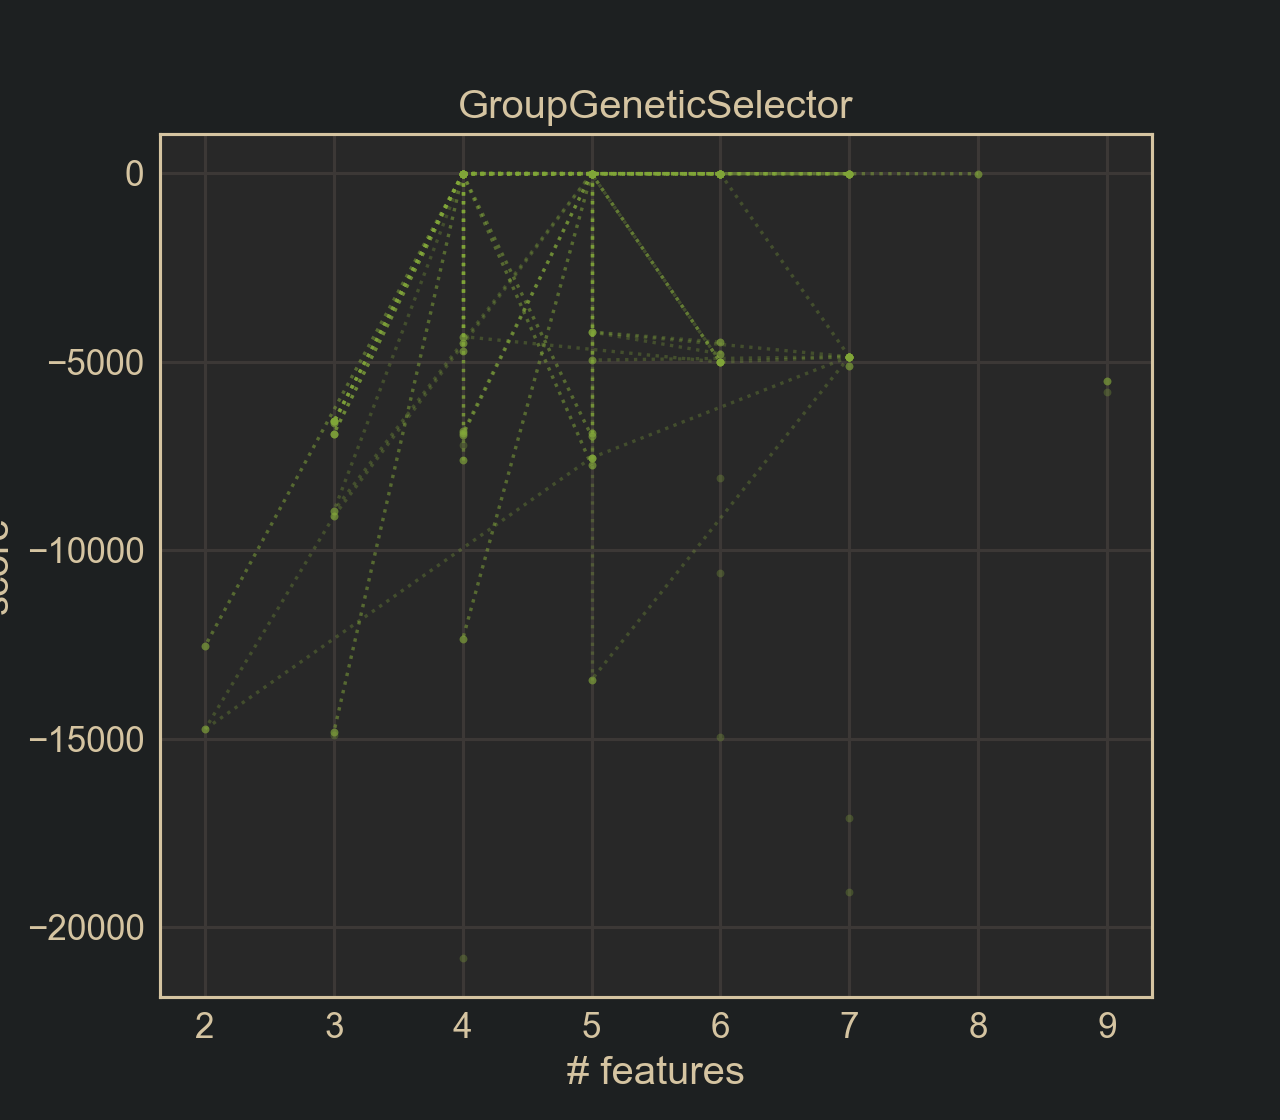

In [46]:
%matplotlib notebook

fig, ax = selector.plot(marker='.', color='g', linestyle=':', alpha=0.3)

In [47]:
subset = selector.get_subset()

_, y_pred = crossval_predict(model, cv, X_train_[subset], y_train, X_new=X_test_[subset],
                             scoring=scoring, verbose=2, n_jobs=-1)

get_score(y_test, y_pred)

[06:09:30]  Ridge

[06:09:30]  FOLD  0:   -2.7817
[06:09:30]  FOLD  1:   -3.3609
[06:09:30]  FOLD  2:   -3.0323
[06:09:30]  FOLD  3:   -6.6054
[06:09:30]  FOLD  4:   -3.0771

[06:09:30]  AVERAGE:   -3.7715 ± 1.4288



-4.25122081203568

In [48]:
subset

FeatureSubset(Index(['x16-x20', 'x28-x32', 'x36-x40', 'x44-x48'], dtype='object'))